In [330]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
# size of the first layer
l1 = 30
#number of epochs 
EPOCHS  = 75

In [332]:

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [333]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        #self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(l1, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

### with injectivity

In [334]:
model_inj     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model_inj.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model_inj

Model(
  (layer1): Linear(in_features=3, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=3, bias=True)
)

In [335]:
# with injectivity
#initialize lists



weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model_inj.layer1.weight
b1 = model_inj.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list_inj     = np.zeros((EPOCHS,))
accuracy_list_inj = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model_inj(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list_inj[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model_inj(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list_inj[epoch] = correct.mean()
    
    
    
    w1 = model_inj.layer1.weight
    b1 = model_inj.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()

    #make injectivity
    est_alpha, subframes, est_points =mcbe.mcbe(polytope=np.array(weights)[-1],N=X_train.shape[0],distribution="ball",radius = np.max(np.array(X_train)), give_subframes=True,sample_on_sphere=False)

    #plot if mcbe is used
    if np.sum(biases[k,:] > est_alpha) > 0:
        print("injectivity violated")
    
    #force injectivity
    biases[k,:] = np.min([biases[k,:], est_alpha], axis = 0)




    
    k = k+1
    

accuracy_list_inj

  8%|▊         | 6/75 [00:00<00:01, 54.69it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


 24%|██▍       | 18/75 [00:00<00:01, 54.85it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


 40%|████      | 30/75 [00:00<00:00, 54.63it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


 56%|█████▌    | 42/75 [00:00<00:00, 53.63it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


 72%|███████▏  | 54/75 [00:01<00:00, 53.36it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


 88%|████████▊ | 66/75 [00:01<00:00, 53.94it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


100%|██████████| 75/75 [00:01<00:00, 53.64it/s]

injectivity violated
injectivity violated
injectivity violated
injectivity violated
injectivity violated


array([0.46666667, 0.56666666, 0.69999999, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.76666665, 0.76666665, 0.80000001, 0.83333331, 0.83333331,
       0.83333331, 0.83333331, 0.83333331, 0.83333331, 0.89999998,
       0.89999998, 0.89999998, 0.93333334, 0.93333334, 0.93333334,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666

### without injectivity

In [336]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [337]:
model_noninj     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model_noninj.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model_noninj

Model(
  (layer1): Linear(in_features=3, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=3, bias=True)
)

In [338]:
# without injectivity
#initialize lists


weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model_noninj.layer1.weight
b1 = model_noninj.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list_noninj     = np.zeros((EPOCHS,))
accuracy_list_noninj = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model_noninj(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list_noninj[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model_noninj(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list_noninj[epoch] = correct.mean()
    
    
    
    w1 = model_noninj.layer1.weight
    b1 = model_noninj.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()

    


    
    k = k+1
    

accuracy_list_noninj

100%|██████████| 75/75 [00:00<00:00, 525.88it/s]


array([0.26666668, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.76666665, 0.83333331, 0.83333331,
       0.83333331, 0.83333331, 0.89999998, 0.89999998, 0.89999998,
       0.93333334, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666

### alway use mcbe

In [339]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [340]:
model_mcbe     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model_mcbe.parameters(), lr=0.01)
loss_fn   = nn.CrossEntropyLoss()
model_mcbe

Model(
  (layer1): Linear(in_features=3, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=3, bias=True)
)

In [341]:
#initialize lists


weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])

w1 = model_mcbe.layer1.weight
b1 = model_mcbe.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

    
weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list_mcbe     = np.zeros((EPOCHS,))
accuracy_list_mcbe = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model_mcbe(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list_mcbe[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model_mcbe(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list_mcbe[epoch] = correct.mean()
    
    
    
    w1 = model_mcbe.layer1.weight
    b1 = model_mcbe.layer1.bias
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()

    #make injectivity
    est_alpha, subframes, est_points =mcbe.mcbe(polytope=np.array(weights)[-1],N=X_train.shape[0],distribution="ball",radius = np.max(np.array(X_train)), give_subframes=True,sample_on_sphere=False)


    
    #use mcbe
    biases[k,:] =  est_alpha




    
    k = k+1
    

accuracy_list_mcbe

100%|██████████| 75/75 [00:01<00:00, 43.44it/s]


array([0.16666667, 0.83333331, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.73333335,
       0.73333335, 0.73333335, 0.73333335, 0.73333335, 0.76666665,
       0.76666665, 0.80000001, 0.83333331, 0.83333331, 0.83333331,
       0.83333331, 0.83333331, 0.83333331, 0.83333331, 0.89999998,
       0.89999998, 0.93333334, 0.93333334, 0.93333334, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666

### compare results

Text(0.5, 1.0, 'Accuracy of the three models')

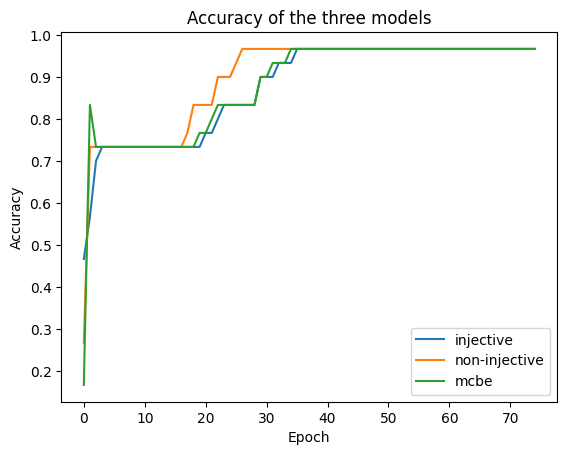

In [342]:
plt.plot(accuracy_list_inj, label = "injective")
plt.plot(accuracy_list_noninj, label = "non-injective")
plt.plot(accuracy_list_mcbe, label = "mcbe")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy of the three models")

Text(0.5, 1.0, 'Loss of the three models')

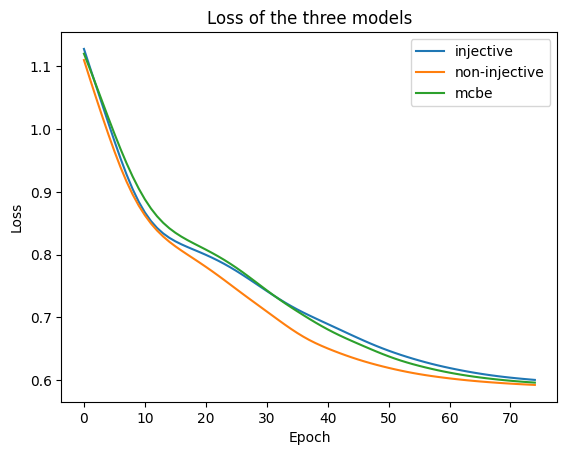

In [343]:
#plot losses
plt.plot(loss_list_inj, label = "injective")
plt.plot(loss_list_noninj, label = "non-injective")
plt.plot(loss_list_mcbe, label = "mcbe")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss of the three models")